<a href="https://colab.research.google.com/github/pkhamchuai/Optimization/blob/main/Multiple_shooting_v_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multiple shooting for IVP

*   Original paper: https://www.sciencedirect.com/science/article/pii/S1474667017612059
*   This is the version taught by Prof Dr. Guido Kanschat in Numerical analysis for ODEs class at Universität Heidelberg in 2016


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [2]:
t0 = 0.0 # time
tn = 5.0

In [3]:
eq_nr =2 # number of ODEs
node_nr = np.arange(10, 20, 1)

ns = node_nr[0] # number of shooting nodes
tm = np.linspace(t0, tn, ns+1) # time at shooting nodes/boundaries
u0 = np.array([1.0, 0.0]) # initial values of u, u(0)
v = np.zeros([eq_nr, ns+1]) # initial values of shooting nodes vk
v[:, 0] = u0 # v0 = u0

# Define functions

In [4]:
def rhs_evaluate(t, u):
  f = lambda t, u: np.array([t*u[1], 4*(u[0]**(3/2))]) # pre-defined ODEs RHS << change
  return f(t, u)
# --------------------

def expl_euler(u0,  t0, tn, h):
  u = u0
  t = t0
  epsilon = 1e-7
  y = u0

  while True:
      f_val = rhs_evaluate(t, u)   # evaluate values of rhs at t
      if abs((t+h) - tn) < epsilon:    # stop computation when we reach tn
          un = u + (h*f_val)           # un = new u
          y = np.vstack([y, un])
          break
      else:
          if t+h > tn:    # reduce step size if we are clse to tn
              h = tn - t
              un = u + (h*f_val)
              y = np.vstack([y, un])
              break
          else:            # normal step size h
            un = u + (h*f_val)
            t = t + h
      y = np.vstack([y, un])
      u = un
  return np.transpose(y)

In [5]:
def integrator_ee(u0, t0, tn, h, y, f):
  # Explicit Euler method integrator for Fundamental Matrix
  # y is values of u(t,u), needed for evaluation of Fundamental Matrix
  # f is the Jacobian/Gradient
  u = u0
  t = t0
  epsilon = 10e-7
  i = 0

  #print(f'integrator_ee y: {y} {y.shape}')
  while True:
      
      f_val = np.dot(f(t, y[0, i]), u) 
      # print(f'integrator_ee: {f(t, y[0, i])} {u}')
      # print(f'fval: {f_val}')
      if abs((t+h) - tn) < epsilon: # stop computation when we reach tn
          un = u + (h*f_val)
          break
      else:
          if t+h > tn:    # reduce step size if we are clse to tn
              h = tn - t
              un = u + (h*f_val)
              break
          else: # normal step size h
              un = u + (h*f_val)
              t = t + h
      u = un;
      i = i+1;
  return un

def compute_fundamental(a, b, d, y, Gradf_u):
  # d = dimension of fundamental matrix
  # need all y solved by IVP to evaluate GradF

  h = 1/30
  U = np.eye(d)
  for i in range(d):
    U[:, i] = integrator_ee(U[:, i], a, b, h, y, Gradf_u)
  return U

# Perform multiple shooting

In [9]:
def MultipleShooting(v, t0, tn, ns):
  
  h = 1/30 # step size for Explicit Euler
  g = v[:, 0] # boundary condition of original problem
  tm = np.linspace(t0, tn, ns+1) # time at shooting nodes/boundaries

  Ba = np.array([[1, 0], [0, 0]]) # Ba = dr(v1, vm+1)/dv1 << change
  Bb = np.array([[0, 0], [1, 0]]) # Bb = dr(v1, vm+1)/dvm+1 << change

  u = np.zeros([eq_nr, ns+1])
  GradF = np.zeros([2*(ns+1), 2*(ns+1)])

  # analytical Jacobian (not used in AutoDiff)
  GradF_func = lambda t, u: [[0, t], [6*np.power(u, (1/2)), 0]]

  # --------------------
  # compute u(i) and GradF(v)
  for i in range(0, ns):   # for every shooting nodes <<< check 1st index!!!
      # print(f'Node: {i}')
      y = expl_euler(v[:, i], tm[i], tm[i+1], h)
      u[:, i] = y[:, -1]      # store values of last y for uk(tk)
      
      if i == 0:
          ua = y[:, 0]        # get ua from 1st subinterval, needed for r <<< check index!!!
      if i == ns-1:
          ub = y[:, -1]      # get ub from last subinterval, needed for r
      
      # to compute GradF: put G, -I, Ba, Bb in their positions
      # G is computed by integration of U_prime over interval of shooting nodes
      # done in compute_Variational func
      
      # switch between analytical and automatic differentiation (AD)
      
      GradF[2*i:2*i+eq_nr, 2*i:2*i+eq_nr] = compute_fundamental(tm[i], tm[i+1], eq_nr, y, GradF_func)
      # GradF[2*i-1:2*i, 2*i-1:2*i] = compute_fundamental_AD(tm[i], tm[i+1], 2, y);
      GradF[2*i:2*i+eq_nr, 2*i+(1*eq_nr):2*i+(2*eq_nr)] = -np.eye(eq_nr)
      GradF[2*ns:2*ns+eq_nr, 0:eq_nr] = Ba
      GradF[2*ns:2*ns+eq_nr, 2*ns:2*ns+eq_nr] = Bb
  print(GradF)
  # --------------------
  r = np.dot(Ba, ua) + np.dot(Bb, ub) - g     # boundary condition function r
  F = compute_F(u, v, r, ns)     # compute F

  # print(f'u1(0) = {ua(0)}')
  # print(f'u2(0) = {ua(1)}')

  # solve linear system GradF*v = -F for v (update of shooting nodes)
  deltav = np.linalg.solve(GradF, -F)

  # --------------------
  # Globalization with line search (with Armijo & Backtracking)
  # reduce Newton step size with t, t = (0,1]
  # t which minimizes F(u, v+t*deltav, r, ns)
  # return deltav = t*deltav
  deltav = backtracking(deltav, u, v, r, ns)
  # --------------------

  return deltav, ua

In [10]:
def compute_F(u, v, r, ns):
  # to computes F, need u, v, r and ns
  F = np.zeros((eq_nr, ns+1))
  for i in range(0, ns): # compute F(v)  << beware index!!
    F[:, i] = u[:, i] - v[:, i+1]

  F[:, -1] = r  # last 2 elements of F(v)
  F = np.reshape(F, (-1, 1))
  return F

def backtracking(deltav, u, v, r, ns):
  # compute a new deltav with backtrackng
  # find t = (0,1] which minimizes F(u, v+t*deltav, r, ns)
  # first check if t = 1 satisfies Armijo (mu = 0)
  # if not, reduce t and check again
  # returns deltav = t*deltav
  # needs u, v, r, ns for compute_F func

  t = 1
  for i in range(18):     # step from t = 1 back to some t that is not so small
      v = np.reshape(v, (-1, 1))
      v_new = v + (t*deltav)
      v_new = np.reshape(v_new, (eq_nr, ns+1))
      v = np.reshape(v, (eq_nr, ns+1))
      
      # compute norm of F(x+td) and F(x)
      normF = np.linalg.norm(compute_F(u, v_new, r, ns))
      normF_old = np.linalg.norm(compute_F(u, v, r, ns))
      
      # if F is "better", return deltav, if not, reduce t and repeat
      # if there is no t satiefies the condition, use t = 1
      if normF < normF_old:
          deltav = t*deltav
          break
      else: t = t - 0.05
  return deltav

### Somehow the Jacobian always explodes, still need to fix
The Matlab version runs fine.

Nodes = 10
[[nan nan -1. -0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.]
 [nan nan -0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.]
 [ 0.  0. nan nan -1. -0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.]
 [ 0.  0. nan nan -0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.]
 [ 0.  0.  0.  0. nan nan -1. -0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.]
 [ 0.  0.  0.  0. nan nan -0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. nan nan -1. -0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. nan nan -0. -1.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. nan nan -1. -0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. nan nan -0. -1.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0. nan nan -1. -0.  

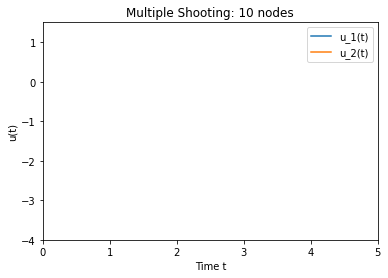

In [13]:
print(f'Nodes = {ns}')
iteration = 0
while True:
  deltav, ua = MultipleShooting(v, t0, tn, ns)
  v = np.reshape(v, (eq_nr*(ns+1), 1))
  v = v + deltav
  v = np.reshape(v, (eq_nr, ns+1))

  print(f'Iteration {iteration}')
  print(f'Norm v: {np.linalg.norm(deltav)}')
  # iterate until deltav is small enough
  if np.linalg.norm(deltav) < 1e-7 or iteration > 2:
    break
  iteration = iteration + 1;

print(f'nr. nodes:  {ns}  nr. iterations: {iteration}')
print(f'ua: {ua}')

plt.figure()
plt.plot(tm, v[0, :].real, '-', label="u_1(t)")
plt.plot(tm, v[1, :].real, '-', label="u_2(t)")
plt.legend()
plt.xlabel('Time t')
plt.ylabel('u(t)')
plt.title('Multiple Shooting: {:d} nodes'.format(ns))
plt.ylim([-4, 1.5])
plt.xlim([0, 5])
plt.show()

  